In [29]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import os
import pickle as pkl
import time
import nltk
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt
tqdm.pandas()
nltk.download('vader_lexicon')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
DATA_FOLDER = 'data/MovieSummaries/'
ADDITIONAL_FOLDER = 'data/AdditionalData/'

In [31]:
# reading a txt file and convert it to a dataframe
def read_txt(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df

In [32]:
# importing the data
plots = pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', header=None, sep="\t")
movies = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', header=None, sep="\t")
characters = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', header=None, sep="\t")
names = pd.read_csv(DATA_FOLDER + 'name.clusters.txt', header=None, sep="\t")
tvtropes = pd.read_csv(DATA_FOLDER + 'tvtropes.clusters.txt', header=None, sep="\t")

In [33]:
# renaming columns the plots dataframe
plots.columns = ['wikipedia_movie_id', 'plot']

In [6]:
# Sample synopsis
synopsis = plots.iloc[:, 1].loc[0]

In [7]:
def find_ending(plot, max_sentences=3):
    blob = TextBlob(plot)
    last_sentences = blob.sentences[-max_sentences:]  
    return " ".join([str(sentence) for sentence in last_sentences])

In [8]:
plots['endings'] = plots.iloc[:, 1].apply(lambda plot: find_ending(plot))
plots['endings']

0        Shlykov, a hard-working taxi driver and Lyosha...
1        However, before they can commit suicide, they ...
2        At Menon's funeral, Manapally Pavithran arrive...
3        Moran and Charley are arrested while the judge...
4        In October 1982, Lindy is found guilty and sen...
                               ...                        
42298    The story is about Reema , a young Muslim scho...
42299    Moved, Leo tells him they have. The assistant ...
42300    Now Parsons is creating instruments that are h...
42301    Mini does not recognize Rehman, who realises t...
42302    Mainwaring and his men become the pride of the...
Name: endings, Length: 42303, dtype: object

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
def attribute_polar_sentiments(text):
    dico = sia.polarity_scores(text)
    return dico['neg'], dico['neu'], dico['pos'], dico['compound']


In [11]:
emotion_pipeline = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=100)

In [12]:
def attribute_multi_sentiments(text):
    try:
        emotions = emotion_pipeline(text)[0]
        
        sorted_emotions = sorted(emotions, key=lambda x: x['label'])
    
        # Extract scores and put them in a tuple
        scores_tuple = tuple(res['score'] for res in sorted_emotions)
        return scores_tuple
    except:
        print(text)
        return (0,0,0,0,0,0)
    
    #emotion_map = {result['label']: result['score'] for result in emotions}
    #return emotion_map



In [13]:
prediction = emotion_pipeline("I am happy " )
attribute_multi_sentiments("I am happy")

(0.0002622490865178406,
 0.00014311514678411186,
 0.998437225818634,
 0.00045619261800311506,
 0.0005438445368781686,
 0.00015750866441521794)

In [14]:
sentiments = plots['endings'].apply(lambda end: attribute_polar_sentiments(end))
sentiments_df = pd.DataFrame(sentiments.tolist(), columns=['ending_negativity', 'ending_neutrality', 'ending_positivity', 'ending_compound_sentiment'])
plots = plots.join(sentiments_df)
plots

,wikipedia_movie_id,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","Shlykov, a hard-working taxi driver and Lyosha...",0.093,0.812,0.095,0.0083
1,31186339,The nation of Panem consists of a wealthy Capi...,"However, before they can commit suicide, they ...",0.171,0.753,0.077,-0.7269
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"At Menon's funeral, Manapally Pavithran arrive...",0.187,0.692,0.122,-0.5719
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",Moran and Charley are arrested while the judge...,0.078,0.791,0.132,0.7096
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"In October 1982, Lindy is found guilty and sen...",0.144,0.843,0.013,-0.9042
...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","The story is about Reema , a young Muslim scho...",0.066,0.843,0.091,0.2732
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","Moved, Leo tells him they have. The assistant ...",0.000,0.652,0.348,0.9231
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Now Parsons is creating instruments that are h...,0.000,0.746,0.254,0.9686
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","Mini does not recognize Rehman, who realises t...",0.034,0.883,0.083,0.4215


In [15]:
#sentiments = plots['endings'].progress_apply(lambda end: attribute_multi_sentiments(end))

In [16]:
#with open(f'{ADDITIONAL_FOLDER}ending_sentiments.pkl', 'wb') as f:
#    pkl.dump(sentiments, f)

with open(f'{ADDITIONAL_FOLDER}ending_sentiments.pkl', 'rb') as f:
    sentiments = pkl.load(f)

In [17]:
sentiments_df = pd.DataFrame(sentiments.tolist(), columns=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])
plots = plots.join(sentiments_df)
plots

,wikipedia_movie_id,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment,anger,fear,joy,love,sadness,surprise
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","Shlykov, a hard-working taxi driver and Lyosha...",0.093,0.812,0.095,0.0083,0.005651,0.620628,0.003627,0.001354,0.003469,0.365272
1,31186339,The nation of Panem consists of a wealthy Capi...,"However, before they can commit suicide, they ...",0.171,0.753,0.077,-0.7269,0.862967,0.072434,0.050531,0.001587,0.011251,0.001230
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"At Menon's funeral, Manapally Pavithran arrive...",0.187,0.692,0.122,-0.5719,0.024590,0.005117,0.934492,0.004668,0.030487,0.000646
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",Moran and Charley are arrested while the judge...,0.078,0.791,0.132,0.7096,0.020590,0.004994,0.965741,0.001478,0.006511,0.000685
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"In October 1982, Lindy is found guilty and sen...",0.144,0.843,0.013,-0.9042,0.144775,0.768390,0.057049,0.002182,0.023313,0.004291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","The story is about Reema , a young Muslim scho...",0.066,0.843,0.091,0.2732,0.016801,0.089359,0.008805,0.025031,0.857494,0.002510
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","Moved, Leo tells him they have. The assistant ...",0.000,0.652,0.348,0.9231,0.000681,0.000264,0.997107,0.000565,0.000669,0.000713
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Now Parsons is creating instruments that are h...,0.000,0.746,0.254,0.9686,0.000996,0.000311,0.995864,0.001760,0.000627,0.000443
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","Mini does not recognize Rehman, who realises t...",0.034,0.883,0.083,0.4215,0.046122,0.017547,0.187119,0.003798,0.743204,0.002210


In [34]:
with open(f'{ADDITIONAL_FOLDER}plots_with_ending_sentiments.pkl', 'rb') as f:
    plots = pkl.load(f)
plots

,wikipedia_movie_id,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment,anger,fear,joy,love,sadness,surprise
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","Shlykov, a hard-working taxi driver and Lyosha...",0.093,0.812,0.095,0.0083,0.005651,0.620628,0.003627,0.001354,0.003469,0.365272
1,31186339,The nation of Panem consists of a wealthy Capi...,"However, before they can commit suicide, they ...",0.171,0.753,0.077,-0.7269,0.862967,0.072434,0.050531,0.001587,0.011251,0.001230
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"At Menon's funeral, Manapally Pavithran arrive...",0.187,0.692,0.122,-0.5719,0.024590,0.005117,0.934492,0.004668,0.030487,0.000646
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",Moran and Charley are arrested while the judge...,0.078,0.791,0.132,0.7096,0.020590,0.004994,0.965741,0.001478,0.006511,0.000685
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"In October 1982, Lindy is found guilty and sen...",0.144,0.843,0.013,-0.9042,0.144775,0.768390,0.057049,0.002182,0.023313,0.004291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","The story is about Reema , a young Muslim scho...",0.066,0.843,0.091,0.2732,0.016801,0.089359,0.008805,0.025031,0.857494,0.002510
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","Moved, Leo tells him they have. The assistant ...",0.000,0.652,0.348,0.9231,0.000681,0.000264,0.997107,0.000565,0.000669,0.000713
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,Now Parsons is creating instruments that are h...,0.000,0.746,0.254,0.9686,0.000996,0.000311,0.995864,0.001760,0.000627,0.000443
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","Mini does not recognize Rehman, who realises t...",0.034,0.883,0.083,0.4215,0.046122,0.017547,0.187119,0.003798,0.743204,0.002210


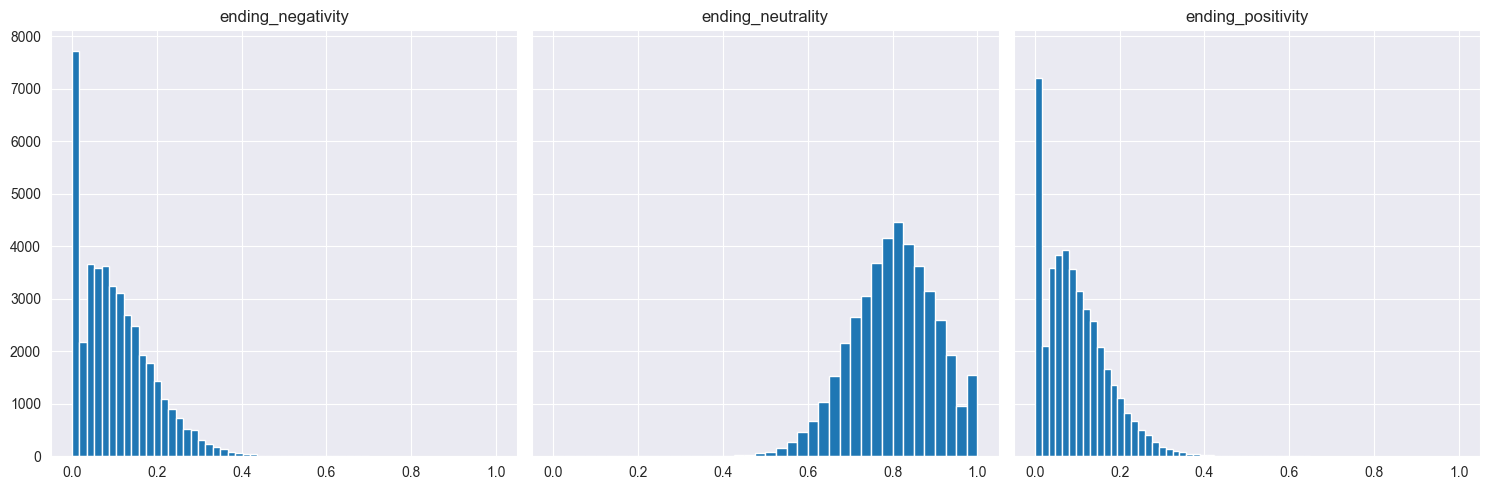

In [18]:
N_ROW = 1
N_COL = 3
fig, axs = plt.subplots(N_ROW, N_COL, figsize=(15, 5), sharey=True,sharex=True)

# Plotting histograms
for idx, col in enumerate(['ending_negativity', 'ending_neutrality', 'ending_positivity']):
    axs[idx].hist(plots[col], bins=40, label=col,)
    axs[idx].set_title(col)

plt.tight_layout()
plt.show()

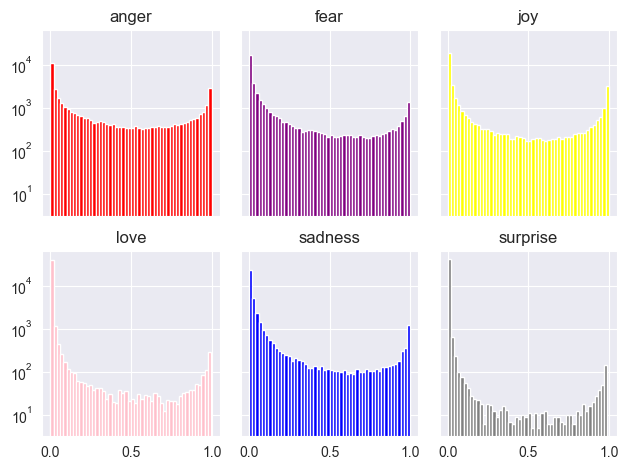

In [25]:
def hist_multi_sentiments(movie_plots,bins=50, ):
    N_ROW = 2
    N_COL = 3
    fig, axs = plt.subplots(N_ROW, N_COL, sharey=True, sharex=True)
    colors = ['red', 'purple', 'yellow', 'pink', 'blue', 'gray']
    for idx, col in enumerate(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']):
        axs[idx//N_COL, idx % N_COL].hist(movie_plots[col], bins=bins, label=col, color=colors[idx])
        axs[idx//N_COL, idx % N_COL].set_yscale('log')
        axs[idx//N_COL, idx % N_COL].set_title(col)
        
    plt.tight_layout()
hist_multi_sentiments(plots)

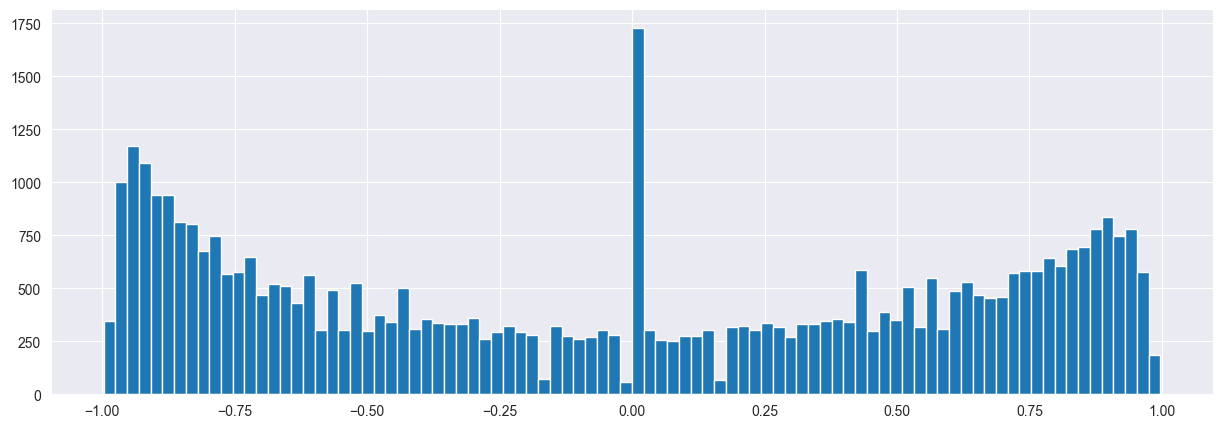

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(plots['ending_compound_sentiment'],bins=90)
plt.show()


In [21]:
plots[(plots['ending_compound_sentiment'] == 0) ]

,wikipedia_movie_id,plot,endings,ending_negativity,ending_neutrality,ending_positivity,ending_compound_sentiment,anger,fear,joy,love,sadness,surprise
8,2462689,Infuriated at being told to write one final co...,The film ends with Connell turning to Norton a...,0.0,1.0,0.0,0.0,0.778707,0.020799,0.171792,0.008422,0.016547,0.003733
39,28238240,Mickey and the Scorpions decide to go on a big...,Mickey and the Scorpions decide to go on a big...,0.0,1.0,0.0,0.0,0.100505,0.712021,0.168468,0.003139,0.008865,0.007002
55,27975390,"Reportedly, the film is about slum kids who ar...","Reportedly, the film is about slum kids who ar...",0.0,1.0,0.0,0.0,0.229969,0.352184,0.381401,0.004977,0.025245,0.006225
68,455089,"Staff Sgt. Raphael ""Jinji"" Moked is ordered by...","When Hasson returns to the base, he discovers ...",0.0,1.0,0.0,0.0,0.658596,0.195375,0.094710,0.004113,0.041967,0.005241
89,457561,Joan is brought to trial. Her judges try to ma...,1970. ISBN 253-12740-8. pp. 27-76.,0.0,1.0,0.0,0.0,0.157569,0.100847,0.585574,0.011039,0.134599,0.010372
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42224,32241787,"Raaj Tilak is an action period drama, featurin...","Raaj Tilak is an action period drama, featurin...",0.0,1.0,0.0,0.0,0.184753,0.205012,0.481588,0.043117,0.062556,0.022973
42235,27685410,First Platoon centers around Rock Brannigan ([...,First Platoon centers around Rock Brannigan ([...,0.0,1.0,0.0,0.0,0.536727,0.163143,0.111719,0.006223,0.022953,0.159236
42271,30103174,Shroff plays Ranbir Saigal and Chaudry plays A...,Tracklisting- 1. mujhse kyun - alka yagnik 2. ...,0.0,1.0,0.0,0.0,0.143395,0.162872,0.650128,0.010333,0.029342,0.003931
42273,277160,"Virginia ""Gin"" Baker is an investigator for W...",She boards a train and the FBI heads to the ne...,0.0,1.0,0.0,0.0,0.779044,0.157596,0.037293,0.002539,0.022494,0.001034


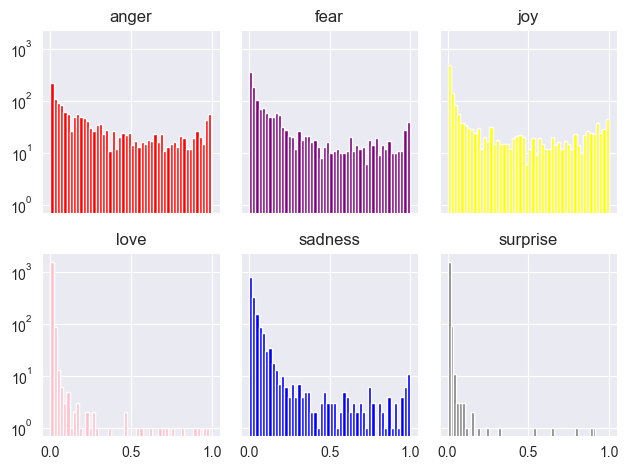

In [26]:
film_with_compound_zero = plots[(plots['ending_compound_sentiment'] == 0) ]
hist_multi_sentiments(film_with_compound_zero)

In [27]:
plots.columns

Index(['wikipedia_movie_id', 'plot', 'endings', 'ending_negativity',
       'ending_neutrality', 'ending_positivity', 'ending_compound_sentiment',
       'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype='object')

In [37]:
# Assuming df is your DataFrame
# Replace 'target' with your actual target column
X = plots[['ending_negativity', 'ending_positivity', 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise']]
# TODO y = plots['movie_score']  # Your target variable


In [38]:

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [39]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [41]:
# Predicting and Evaluating
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred)

# Printing evaluation metrics
print("Accuracy:", accuracy)
#print("ROC AUC:", roc_auc)

# Obtaining Propensity Scores
propensity_scores = model.predict_proba(X)[:, 1]  # Probabilities of the positive class

Accuracy: 0.0
